# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Catrina Herman
- Gabriella Martinez
- Berke Maltepe
- Arav Kumar

In [47]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [49]:
# Function to download the data
def download_data():
    # PR Urban Population Growth
    url1 = 'https://api.worldbank.org/V2/country/PRI/indicator/SP.URB.GROW?format=json'
    response1 = requests.get(url1)
    PR_pop_growth = response1.json()
    # print(PR_pop_growth[1])

    # PR GDP per Capita
    url2 = 'https://api.worldbank.org/V2/country/PRI/indicator/NY.GDP.PCAP.CD?format=json'
    response2 = requests.get(url2)
    PR_gdp = response2.json()
    PR_gdp
    # print(PR_gdp[1])

    # PR Migration Data
    url3 = 'https://api.worldbank.org/V2/country/PRI/indicator/SM.POP.NETM?format=json'
    response3 = requests.get(url3)
    PR_migration = response3.json()
    # print(PR_migration[1])

    return PR_pop_growth, PR_gdp, PR_migration

In [51]:
# Function to merge the data frames
def merge_data_frames(PR_pop_growth, PR_gdp, PR_migration):
    pop_growth_df = pd.json_normalize(PR_pop_growth[1])
    pop_growth_df = pop_growth_df[['date', 'value']]
    pop_growth_df = pop_growth_df.rename(columns={'value': 'Urban Population Growth'})

    gdp_df = pd.json_normalize(PR_gdp[1])
    gdp_df = gdp_df[['date', 'value']]
    gdp_df = gdp_df.rename(columns={'value': 'GDP Per Capita'})

    migration_df = pd.json_normalize(PR_migration[1])
    migration_df = migration_df[['date', 'value']]
    migration_df = migration_df.rename(columns={'value': 'Migration'})

    merged_df = pd.merge(pop_growth_df, gdp_df, on='date')
    PR_df = pd.merge(merged_df, migration_df, on='date')
    
    return PR_df

In [53]:
# Function to clean the dataset
def clean_data(df):
    """
    Cleans the merged dataframe by performing various transformations and removing invalid data.
    
    Args:
        df (pd.DataFrame): DataFrame containing the raw data.
    
    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    
    # Make a categorical column for decade
    decades = []
    for value in df['date']:
        decade = value[0:3] + '0'
        decades.append(decade)

    df['decade'] = decades
    df["date"] = pd.to_numeric(df["date"])
    
    # Unify NaN values into one type
    df.replace({"n/a": pd.NA, "\n": pd.NA, r"\N": pd.NA}, inplace=True)
    
    required_columns = [
        'Urban Population Growth', 'GDP Per Capita', 'Migration',
        'decade', 'date'
    ]
    
    df.dropna(subset=required_columns, inplace=True)

    return df

## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [58]:
# Function to preprocess the data
def load_and_preprocess_data():
    """
    Preprocess the data by cleaning the necessary columns and creating derived features.
    
    Args:
        df (pd.df): dataframe to preprocess
    
    Returns:
        df (pd.df): fully preprocessed and organized data to analyze for ML
    """
    pop_growth, gdp, migration = download_data()
    data = merge_data_frames(pop_growth, gdp, migration)
    cleaned_data = clean_data(data)

    return cleaned_data

In [60]:
data = load_and_preprocess_data()
data.head()

,date,Urban Population Growth,GDP Per Capita,Migration,decade
0,2023,-0.423241,36779.059491,19833,2020
1,2022,-1.294422,35268.079102,16704,2020
2,2021,-0.564747,32619.250417,-7410,2020
3,2020,2.719327,31427.429114,-7410,2020
4,2019,0.008500,32916.866801,10623,2010


### Attempt 1 - Linear Regression

In [63]:
def build_linear_models(df, target='Urban Population Growth'):
    """Build and evaluate linear regression models"""
    print(f"\nBuilding regression models for {target}")
    
    features = ['GDP Per Capita', 'Migration']
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    print("\nLinear Regression Results:")
    print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lr):.4f}")
    print("Coefficients:")
    for feature, coef in zip(features, lr.coef_):
        print(f"  {feature}: {coef:.6f}")
    print(f"Intercept: {lr.intercept_:.6f}")
    
    # Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    
    print("\nRidge Regression Results:")
    print(f"R² Score: {r2_score(y_test, y_pred_ridge):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_ridge):.4f}")
    
    # Lasso Regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    
    print("\nLasso Regression Results:")
    print(f"R² Score: {r2_score(y_test, y_pred_lasso):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lasso):.4f}")
    
    # Plot linear regression results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test['GDP Per Capita'], y_test, color='blue', label='Actual', alpha=0.5)
    plt.scatter(X_test['GDP Per Capita'], y_pred_lr, color='red', label='Predicted', alpha=0.5)
    plt.plot(X_test['GDP Per Capita'], y_pred_lr, color='green', label='Regression Line', linewidth=2)
    plt.title('Linear Regression: Actual vs Predicted')
    plt.xlabel('GDP Per Capita')
    plt.ylabel('Urban Population Growth')
    plt.legend()
    plt.grid()
    plt.show()

    return lr, ridge, lasso


Building regression models for Urban Population Growth

Linear Regression Results:
R² Score: 0.5863
Mean Squared Error: 1.0832
Coefficients:
  GDP Per Capita: -0.000169
  Migration: 0.000014
Intercept: 4.245414

Ridge Regression Results:
R² Score: 0.5863
Mean Squared Error: 1.0832

Lasso Regression Results:
R² Score: 0.5863
Mean Squared Error: 1.0831


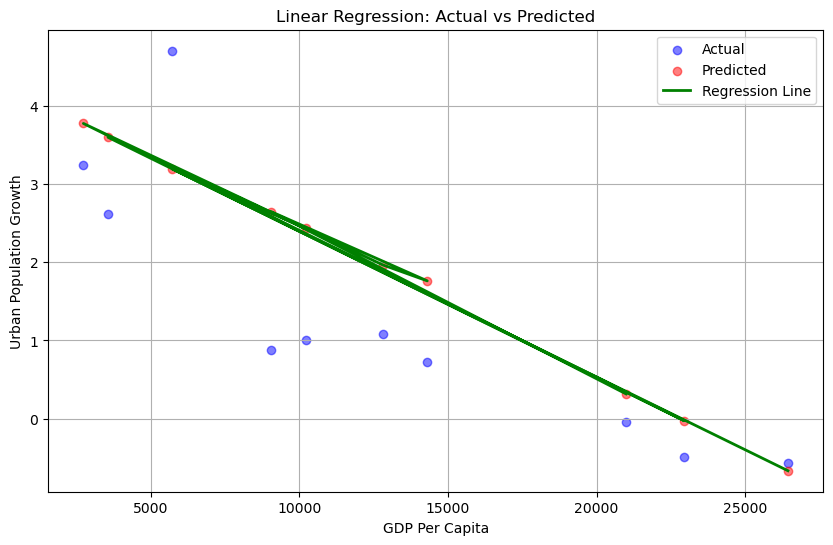

(LinearRegression(), Ridge(), Lasso(alpha=0.1))

In [65]:
build_linear_models(data)

### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [68]:
def build_polynomial_regression(df, target='Urban Population Growth', degree=2):
    """Build and evaluate polynomial regression models"""
    print(f"\nBuilding polynomial regression model (degree={degree}) for {target}")
    
    features = ['GDP Per Capita', 'Migration']
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Polynomial Regression
    poly_model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    poly_model.fit(X_train, y_train)
    y_pred_poly = poly_model.predict(X_test)
    
    print("\nPolynomial Regression Results:")
    print(f"R² Score: {r2_score(y_test, y_pred_poly):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_poly):.4f}")

    gdp_range = np.linspace(X_test['GDP Per Capita'].min(), X_test['GDP Per Capita'].max(), 100)
    gdp_range = gdp_range.reshape(-1, 1)
    gdp_poly = poly_model.named_steps['polynomialfeatures'].transform(np.hstack((gdp_range, np.zeros_like(gdp_range))))
    y_poly_pred = poly_model.named_steps['linearregression'].predict(gdp_poly)

    # Plot polynomial regression line
    plt.scatter(X_test['GDP Per Capita'], y_test, color='blue', label='Actual Data', alpha=0.5)
    plt.plot(gdp_range, y_poly_pred, color='red', label='Polynomial Regression Line', linewidth=2)
    plt.title('Polynomial Regression: Actual vs Predicted')
    plt.xlabel('GDP Per Capita')
    plt.ylabel('Urban Population Growth')
    plt.legend()
    plt.grid()
    plt.show()
    
    return poly_model

In [70]:
def build_random_forest(df, target='Urban Population Growth'):
    """Build and evaluate random forest regression model"""
    print(f"\nBuilding random forest regression model for {target}")

    features = ['GDP Per Capita', 'Migration']
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Random Forest Regression
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    
    print("\nRandom Forest Regression Results:")
    print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_rf):.4f}")
    
    # Feature importance
    print("\nFeature Importance:")
    for feature, importance in zip(features, rf.feature_importances_):
        print(f"  {feature}: {importance:.4f}")
    
    # Plotting the Random Forest Regression results
    plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linewidth=2, linestyle='--')
    plt.title('Random Forest Regression: Actual vs Predicted')
    plt.xlabel('Actual Urban Population Growth')
    plt.ylabel('Predicted Urban Population Growth')
    plt.grid()
    plt.show()
    
    return rf


Building polynomial regression model (degree=2) for Urban Population Growth

Polynomial Regression Results:
R² Score: 0.7582
Mean Squared Error: 0.6331


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


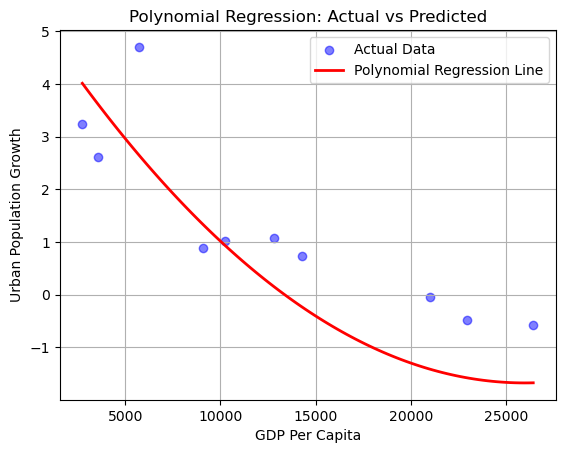

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [72]:
build_polynomial_regression(df=data, degree=2)


Building random forest regression model for Urban Population Growth

Random Forest Regression Results:
R² Score: 0.8996
Mean Squared Error: 0.2629

Feature Importance:
  GDP Per Capita: 0.8673
  Migration: 0.1327


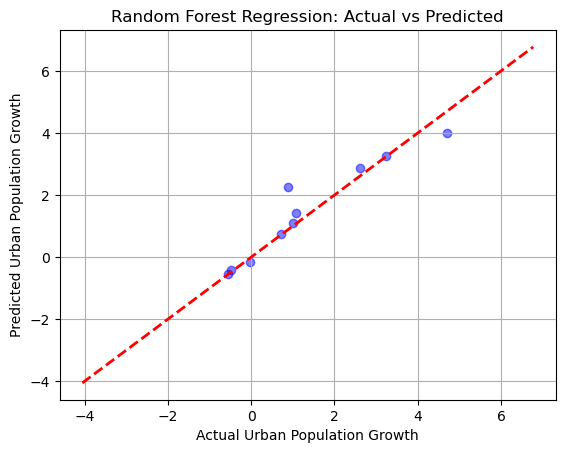

RandomForestRegressor(random_state=42)

In [74]:
build_random_forest(data)

### Model Evaluation

In this section, we evaluate the performance of various regression models using cross-validation. This allows us to assess how well each model generalizes to unseen data by calculating the R² score across multiple folds. After evaluating the models, we will use the best-performing model to make predictions for future values of urban population growth, providing insights into potential trends over the next few years.

In [ ]:
def cross_validate(model, X, y):
    crossval = train_test_split(X, y, test_size=0.3, random_state=3)
    Xtrain, Xtest, ytrain, ytest = crossval

In [95]:
def compare_models(df, target='Urban Population Growth'):
    """Compare all models using cross-validation"""
    from sklearn.model_selection import cross_val_score
    
    print(f"\nComparing models for {target} using 5-fold cross-validation")
    
    features = ['GDP Per Capita', 'Migration']
    X = df[features]
    y = df[target]
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Polynomial Regression (degree=2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    # Perform cross-validation
    results = {}
    for name, model in models.items():
        r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  
        mse_scores = -mse_scores
        results[name] = {'R2': r2_scores, 'MSE': mse_scores}
        print(f"{name}:")
        print(f"  Mean R² = {r2_scores.mean():.4f} (Std: {r2_scores.std():.4f})")
        print(f"  Mean MSE = {mse_scores.mean():.4f} (Std: {mse_scores.std():.4f})\n")
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.boxplot([results[name]['R2'] for name in models.keys()], labels=list(models.keys()), vert=False)
    plt.title(f'Model Comparison for Predicting {target}')
    plt.xlabel('R² Score (higher is better)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('model_comparison_r2.png')

    plt.figure(figsize=(12, 6))
    plt.boxplot([results[name]['MSE'] for name in models.keys()], labels=list(models.keys()), vert=False)
    plt.title(f'Model Comparison for Predicting {target}')
    plt.xlabel('MSE Score (lower is better)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('model_comparison_ms.png')


Comparing models for Urban Population Growth using 5-fold cross-validation
Linear Regression:
  Mean R² = -2.7728 (Std: 3.8735)
  Mean MSE = 7.4994 (Std: 12.0410)

Ridge Regression:
  Mean R² = -2.7728 (Std: 3.8735)
  Mean MSE = 7.4994 (Std: 12.0410)

Lasso Regression:
  Mean R² = -2.7725 (Std: 3.8728)
  Mean MSE = 7.4984 (Std: 12.0391)

Polynomial Regression (degree=2):
  Mean R² = -65.1210 (Std: 129.9746)
  Mean MSE = 187.5493 (Std: 373.1871)

Random Forest:
  Mean R² = -0.1365 (Std: 0.5248)
  Mean MSE = 1.6175 (Std: 1.2033)



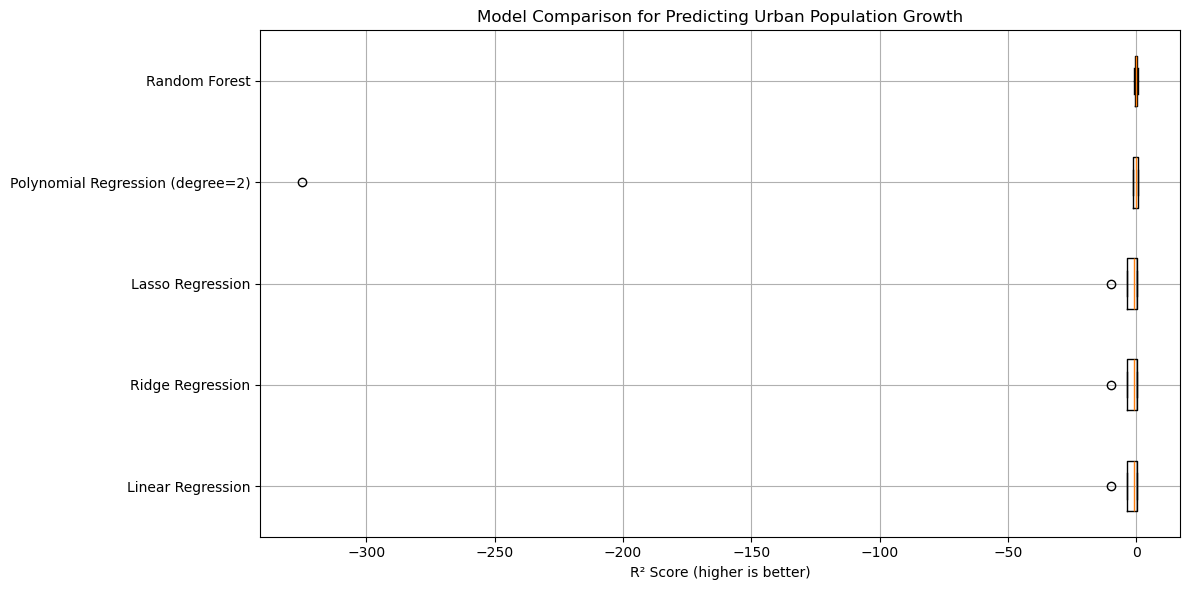

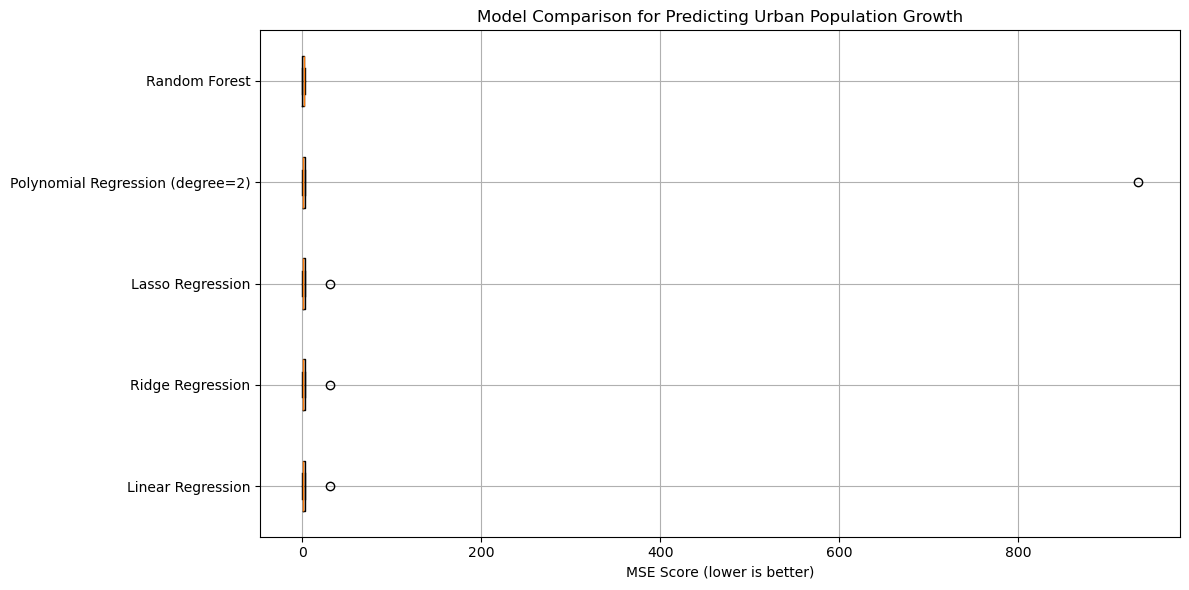

In [97]:
compare_models(data)

In [80]:
def predict_future_values(model, df, years_ahead=5, target='Urban Population Growth'):
    """Predict future values using the best model"""
    print(f"\nPredicting {target} for the next {years_ahead} years")

    latest_year = df['date'].dt.year.max()
    
    future_features = []
    for i in range(1, years_ahead + 1):
        year = latest_year + i
        avg_gdp_growth = df['GDP Per Capita'].pct_change().mean()
        latest_gdp = df['GDP Per Capita'].iloc[-1]
        projected_gdp = latest_gdp * (1 + avg_gdp_growth) ** i
        
        avg_migration = df['Migration'].mean()
        
        years_since_start = df['years_since_start'].max() + i
        
        future_features.append([projected_gdp, avg_migration, years_since_start])
    
    future_df = pd.DataFrame(
        future_features, 
        columns=['GDP Per Capita', 'Migration', 'years_since_start'],
        index=pd.date_range(start=f"{latest_year+1}-01-01", periods=years_ahead, freq='AS')
    )
    
    predictions = model.predict(future_df)
    
    results_df = pd.DataFrame({
        'Year': future_df.index.year,
        f'Predicted {target}': predictions,
        'GDP Per Capita': future_df['GDP Per Capita'],
        'Migration': future_df['Migration']
    })
    
    print(results_df)
    return results_df

## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

### Analysis of Model 1: Linear Regression
Our first model utilized linear regression to predict urban population growth in Puerto Rico. According to the R^2 value calculated, the linear regression model we created can explain 58.63% of the variance in urban population growth. This value indicates that the model does not capture a significant amount of the patterns in the data, making it an okay fit for the data but not a favorable one. GDP per capita had a coefficient of -0.000169, suggesting that it has a very slight negative relationship with urban population. However, this value is so small that it is not very significant. Similarly, the migration coefficient is .000014, suggesting that migration is not a significant predictor for urban growth. The ridge and lasso regressions we conducted yielded similar numbers, indicating very comparable results.

### Analysis of Model 2: Polynomial Regression
Our second model utilized polynomial regression with the same features in an attempt to predict urban population growth. This model seemed to be an improvement from our first model, as it yeilded an R^2 value of .7582. This suggests that this model was able to explain 75.82% of the variance in urban population growth, which is more significant than 58.63% in our linear regression model. Thus, this R^2 indicates that the relationship between the 3 data values is nonlinear. Our MSE for this model was .6331, which was lower than the MSE for our linear model. Thus, this model produces better predictions than the previous.

### Analysis of Model 3: Random Forest Regression
We also looked at a random forest regression model in attempt to reduce overfitting and increase accuracy. The model's R^2 value was 0.9012, which indicates a strong fit as most of the variance in urban population growth is explained by the model. Additionally, the MSE for this model was 0.2588, which was lower than both the previous models and suggests the model's predictions are close to the actual values. Finally, the feautre importance of GDP per capita was 86.67%, suggesting that economic growth strongly correlates with urban expansion. Migration has a lower feature importance, at 13.33%, so GDP per capita is a stronger driver of urban population growth than migration.

### Analysis of Model 4: Comparing Models using Cross Validation
To evaluate different regression models for predicting urban population growth, we conducted a 5-fold cross-validation and analyzed their R² scores using a box plot. The x-axis represents the R² values, while the y-axis lists the different types of regression models. The analysis shows that linear, ridge, and lasso regressions all yielded almost identical results, with mean R^2 values of -2.77 and standard deviation values of 3.87. These models did not perform well and failed to capture significant patterns in the data. All three of these models also had a significant outlier much lower than the typical range. From the statistics of the cross validation the polynomial regression performed the worst, even though it was an improvement from the linear regression in our early analysis. It had a very high standard deviation and very negative R^2 value. The polynomial model had an outlier as well, this one far more negative than the other models. The random forest regression performed the best, with a mean R^2 value of -0.1394 and standard deviation of 0.5284. This model was more stable and better at capturing relationships in the data.  